## Домашка 1
#### *«Великаны — как луковицы. Лук многослоен! Я тоже! Слой за слоем. Ты усёк? Мы многослойные!» — Шрек*

Эта домашка про декомпозицию и срезы. За неё можно получить максимум 6 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Скачайте этот ноутбук.
2. Решите задания (локально или в Google Colab).
3. Опубликуйте решенный ноутбук в свой GitHub репозиторий (проверьте, чтобы он был публичным).
4. Приложите ссылку на решение в Яндекс-Форму для сдачи ДЗ (будет доступна на LMS Karpov Courses и в Телеграм-канале курса).

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.


Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_1_data.zip)

In [133]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

### Case Study. Что-то пошло не так в маркетплейсе 🛒

**Легенда**  
Вы работаете продуктовым аналитиком в маркетплейсе. Ваша команда отвечает за функционал корзины — точки входа, дизайн и функционал самой корзины, путь пользователя с момента добавления товара в корзину и до оформления покупки.

Компания — стартап без системы автоматического мониторинга. Поэтому последние 14 дней, пока вы были в отпуске, никто не следил за метриками корзины.

Вы отлично отдохнули и в первый же день после каникул рвётесь в бой. Наливаете чашку кофе, открываете ноутбук и проверяете, что творилось в ваше отсутствие.

In [134]:
#df = pd.read_parquet('data/hw_1_marketplace_data.parquet')

In [135]:
df = pd.read_parquet('/content/hw_1_marketplace_data.parquet')

In [136]:
df.head()

,user_id,session_id,event_ts,platform,app_version,region,channel,category,event,product_id,price,quantity
0,30,1094418511,2025-04-01 19:49:57,Desktop,web,siberia,ads_search,None,search,NaN,NaN,NaN
1,30,1094418511,2025-04-01 20:02:23,Desktop,web,siberia,ads_search,electronics,view_item,123443.0,NaN,NaN
2,30,1094418511,2025-04-01 20:22:53,Desktop,web,siberia,ads_search,fashion,view_item,162950.0,NaN,NaN
3,30,1094418511,2025-04-01 20:40:57,Desktop,web,siberia,ads_search,home,view_item,199979.0,NaN,NaN
4,30,1094418511,2025-04-01 20:41:07,Desktop,web,siberia,ads_search,home,add_to_cart,199979.0,NaN,NaN


Описание данных

- user_id — уникальный идентификатор пользователя
- session_id — уникальный идентификатор сессии
- event_ts — таймстемп событий
- platform — платформа, с которой пришло событие
- app_version — версия приложения (существует только для iOS и Android, для остальных платформ приходят значения-заглушки)
- region — регион пользователя
- channel — канал, с которого пришел пользователь
- category — категория товаров, которой принадлежит ивент
- event — событие, совершенное пользователем
- product_id — идентификатор товара для событий над товарами
- price — цена товара, ивент приходит только для события покупки
- quantity — количество товаров, ивент приходит только для события покупки

#### **1. Детекция проблемы — 1 балл**

1) Посчитайте подневные конверсии: из просмотра в покупку, из просмотра в добавление в корзину, из добавления в корзину — в покупку.
2) Визуализируйте полученную динамику.
3) Опишите, что вы видите на графике: когда и в каких метриках началось падение? есть ли устойчивый тренд?

*К подсчёту конверсий можно подойти разными способами — считать их по событиям, сессиям или уникальным юзерам. В нашей задаче будем считать по сессиям.*

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266831 entries, 0 to 266830
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      266831 non-null  int64         
 1   session_id   266831 non-null  int64         
 2   event_ts     266831 non-null  datetime64[ns]
 3   platform     266831 non-null  object        
 4   app_version  266831 non-null  object        
 5   region       266831 non-null  object        
 6   channel      266831 non-null  object        
 7   category     266831 non-null  object        
 8   event        266831 non-null  object        
 9   product_id   224687 non-null  float64       
 10  price        7381 non-null    float64       
 11  quantity     7381 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 24.4+ MB


In [138]:
# your code is here

# Создаем столбец с датами без времени
df['date'] = df['event_ts'].dt.date

# Интересующие события
events_of_interest = ['view_item', 'add_to_cart', 'purchase']

# Берём только нужные события
filtered = df[df['event'].isin(events_of_interest)]

# события для каждой сессии и дня
session_events = (
    filtered.groupby(['session_id', 'date'])['event']
    .agg(set)
    .reset_index()
)

In [139]:
session_events

,session_id,date,event
0,1000085798,2025-04-06,"{add_to_cart, purchase, view_item}"
1,1000314036,2025-04-04,{view_item}
2,1000373856,2025-04-25,{view_item}
3,1000441933,2025-04-12,"{add_to_cart, purchase, view_item}"
4,1000686052,2025-04-01,"{add_to_cart, view_item}"
...,...,...,...
70100,9999317343,2025-04-12,"{add_to_cart, view_item}"
70101,9999435208,2025-04-13,{view_item}
70102,9999454270,2025-04-26,"{add_to_cart, view_item}"
70103,9999480568,2025-04-28,{view_item}


In [140]:
# Флаги конверсий
session_events['view_to_cart'] = session_events['event'].apply(lambda x: 'view_item' in x and 'add_to_cart' in x)
session_events['view_to_purchase'] = session_events['event'].apply(lambda x: 'view_item' in x and 'purchase' in x)
session_events['cart_to_purchase'] = session_events['event'].apply(lambda x: 'add_to_cart' in x and 'purchase' in x)
session_events['view_item'] = session_events['event'].apply(lambda x: 'view_item' in x)
session_events['add_to_cart'] = session_events['event'].apply(lambda x: 'add_to_cart' in x)
session_events['purchase'] = session_events['event'].apply(lambda x: 'purchase' in x)

# Группировка по дням
daily_summary = (
    session_events
    .groupby('date')[['view_to_cart', 'view_to_purchase', 'cart_to_purchase', 'view_item', 'add_to_cart', 'purchase']]
    .sum()
    .reset_index()
)

# Подсчёт конверсий по дням
daily_conversions = daily_summary
daily_conversions['conv_view_to_cart'] = daily_conversions['view_to_cart'] / daily_conversions['view_item']
daily_conversions['conv_view_to_purchase'] = daily_conversions['view_to_purchase'] / daily_conversions['view_item']
daily_conversions['conv_cart_to_purchase'] = daily_conversions['cart_to_purchase'] / daily_conversions['add_to_cart']
daily_conversions.head()

,date,view_to_cart,view_to_purchase,cart_to_purchase,view_item,add_to_cart,purchase,conv_view_to_cart,conv_view_to_purchase,conv_cart_to_purchase
0,2025-04-01,633,209,209,1949,633,209,0.324782,0.107234,0.330174
1,2025-04-02,677,208,208,2092,677,208,0.323614,0.099426,0.307238
2,2025-04-03,668,201,201,2124,668,201,0.314501,0.094633,0.300898
3,2025-04-04,764,215,215,2291,764,215,0.333479,0.093845,0.281414
4,2025-04-05,1049,337,337,3187,1049,337,0.329150,0.105742,0.321258


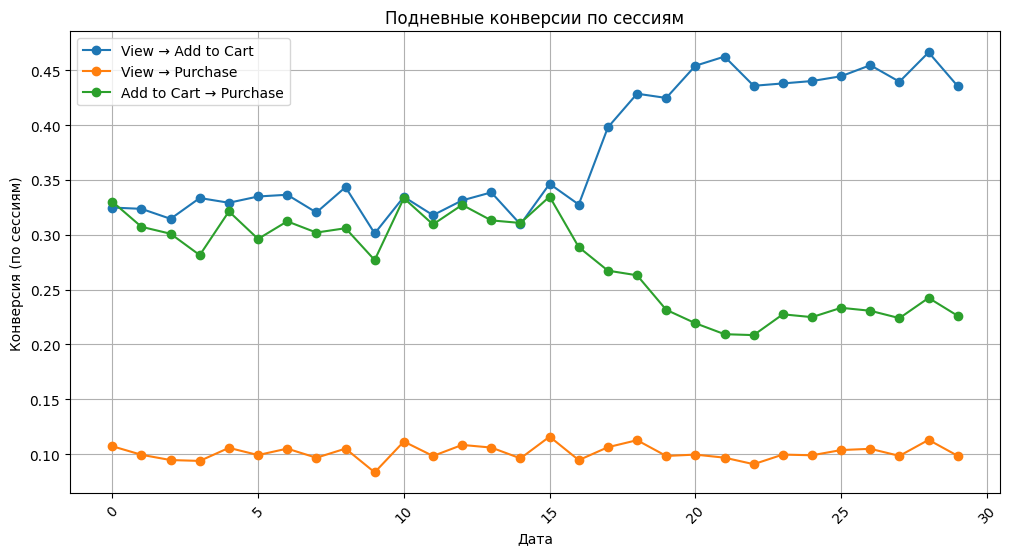

In [141]:
# Визуализация
plt.figure(figsize=(12,6))
plt.plot(daily_conversions.index, daily_conversions['conv_view_to_cart'], marker='o', label='View → Add to Cart')
plt.plot(daily_conversions.index, daily_conversions['conv_view_to_purchase'], marker='o', label='View → Purchase')
plt.plot(daily_conversions.index, daily_conversions['conv_cart_to_purchase'], marker='o', label='Add to Cart → Purchase')
plt.xlabel('Дата')
plt.ylabel('Конверсия (по сессиям)')
plt.title('Подневные конверсии по сессиям')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

- View в Add to Cart
Примерно до 15 числа колебалась вокруг 0.32–0.34. После этого начался заметный рост, и во второй половине месяца метрика стабилизировалась на уровне 0.44–0.46.
Рост устойчивый, падений не видно.

- Add to Cart в Purchase
До середины месяца конверсия держалась в районе 0.30-0.33, но начиная примерно с 16 числа началось падение. К 20 числу опустилась до 0.21, а дальше закрепилась на новом, более низком уровне (0.21-0.24).
Падение произошло резко и тренд устойчиво остаётся низким.

- View в Purchase
Весь месяц держится в диапазоне 0.09-0.11, без ярко выраженного тренда.
Метрика стабильна, изменений нет.

#### **2. Проверка абсолютных и средних значений — 1 балл**

1) Постройте графики дневной динамики абсолютных значений, из которых рассчитаны конверсии выше.
2) Рассчитайте и визуализируйте среднее число событий (именно событий, не сессий), из которых рассчитаны конверсии, на пользователя.
3) На каком этапе воронки появилась проблема?

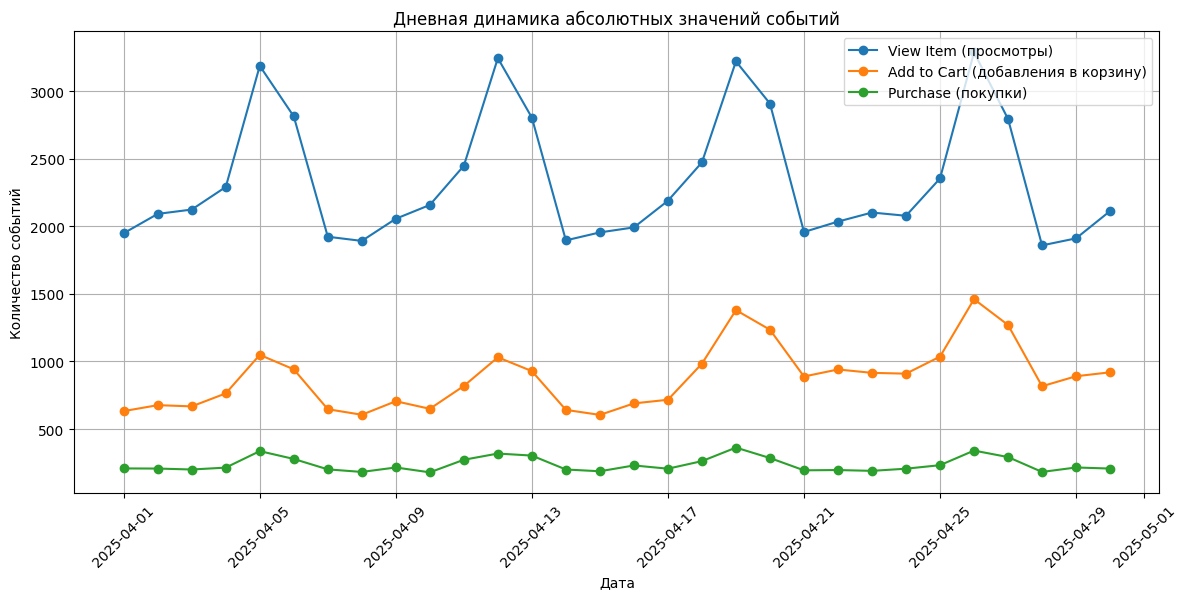

In [142]:
# your code is here

plt.figure(figsize=(14, 6))

plt.plot(daily_conversions['date'], daily_conversions['view_item'], marker='o', label='View Item (просмотры)')
plt.plot(daily_conversions['date'], daily_conversions['add_to_cart'], marker='o', label='Add to Cart (добавления в корзину)')
plt.plot(daily_conversions['date'], daily_conversions['purchase'], marker='o', label='Purchase (покупки)')

plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Дневная динамика абсолютных значений событий')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

event       view_item  add_to_cart  purchase
date                                        
2025-04-01   2.853890     0.461101  0.137887
2025-04-02   2.967465     0.468386  0.130755
2025-04-03   2.978142     0.472374  0.125683
2025-04-04   2.969900     0.483278  0.126533
2025-04-05   3.284951     0.543188  0.155833


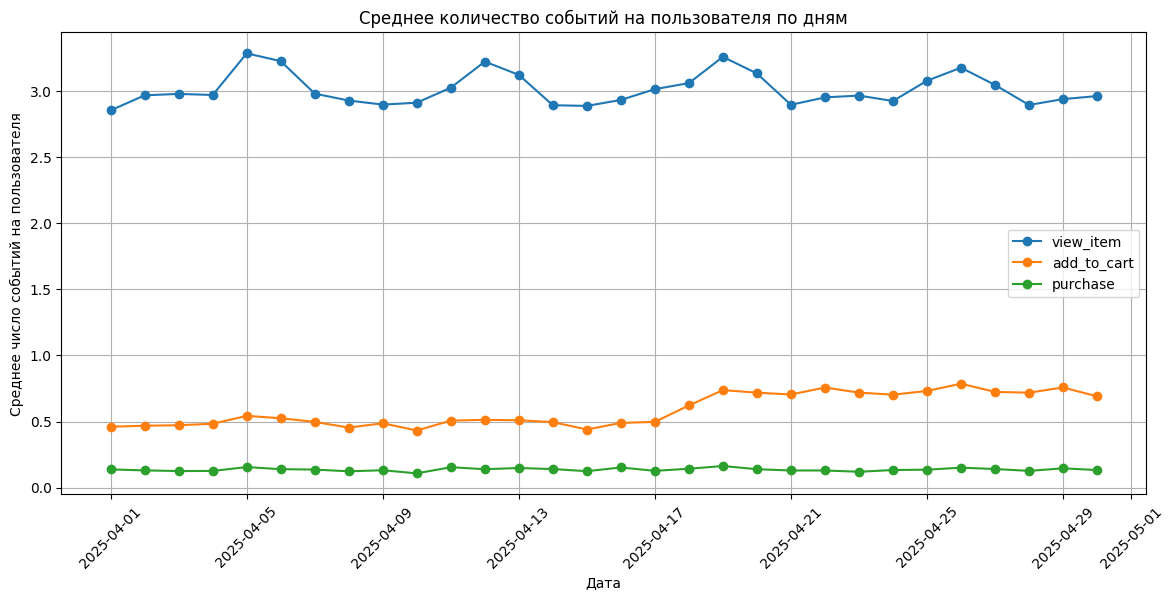

In [143]:
# Считаем количество событий по дням и пользователям
events_per_day_user = (
    df.groupby(['date', 'user_id'])['event']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Оставляем только интересующие события
events_of_interest = ['view_item', 'add_to_cart', 'purchase']
events_per_day_user = events_per_day_user[['date', 'user_id'] + [col for col in events_of_interest if col in events_per_day_user]]

# Считаем среднее число событий на пользователя по дням
daily_avg_events = events_per_day_user.groupby('date')[events_of_interest].mean()

print(daily_avg_events.head())

plt.figure(figsize=(14,6))

for col in daily_avg_events.columns:
    plt.plot(daily_avg_events.index, daily_avg_events[col], marker='o', label=col)

plt.xlabel('Дата')
plt.ylabel('Среднее число событий на пользователя')
plt.title('Среднее количество событий на пользователя по дням')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

event
view_item      7.438563
add_to_cart    1.454604
purchase       0.338283
dtype: float64


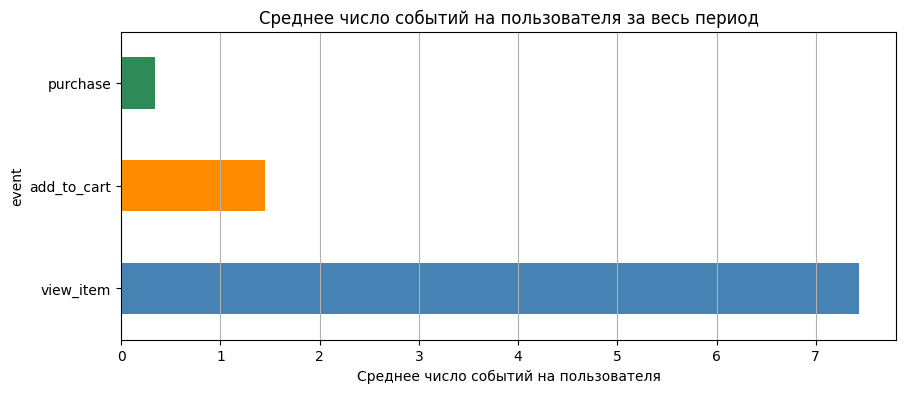

In [144]:
# Считаем количество событий на пользователя за весь период
events_per_user = (
    df.groupby(['user_id'])['event']
    .value_counts()
    .unstack(fill_value=0)
)

events_of_interest = ['view_item', 'add_to_cart', 'purchase']
events_per_user = events_per_user[[col for col in events_of_interest if col in events_per_user]]

# Среднее число событий на пользователя (за весь период)
avg_events_per_user = events_per_user.mean()

print(avg_events_per_user)

plt.figure(figsize=(10,4))
avg_events_per_user.plot(kind='barh', color=['steelblue','darkorange','seagreen'])
plt.xlabel('Среднее число событий на пользователя')
plt.title('Среднее число событий на пользователя за весь период')
plt.grid(axis='x')
plt.show()

- Просмотры (view_item)

Абсолютные значения стабильны (колебания — скорее сезонность по дням недели).

Среднее количество просмотров на пользователя остаётся в районе 3 и не падает.
Проблем на этом этапе не вижу.

- Добавления в корзину (add_to_cart)

Абсолютные значения идут параллельно просмотрам, без резкого падения.

Среднее число на пользователя заметно выросло после середины месяца (с 0.5 до 0.8).
Пользователи даже чаще добавляют товары в корзину.

- Покупки (purchase)

Абсолютные значения остаются относительно стабильными (циклы есть, но тренда роста/падения нет).

Среднее число покупок на пользователя остаётся низким и практически не меняется (0.1–0.15).
На фоне роста добавлений в корзину конверсии в покупку падают.

**Где проблема**

На этапе из корзины в покупку (Add to Cart в Purchase).

Здесь резкое падение после середины месяца. Это значит, что пользователи по-прежнему активно добавляют товары в корзину, но перестали доводить корзину до покупки.

Пользователи активно просматривают и добавляют товары,но оформляют покупку реже.

**Возможные причины:**

- баги или неудобства в корзине при оплате.

- рост цен/стоимости доставки как следствие отказ от покупки.

- пользователи используют корзину как "избранное", значит "избранным" тало пользоваться менее удобно.

#### **3. Базовые срезы — 1 балл**
1. Постройте динамику проблемного события в разрезе:
- платформ,
- регионов,
- источников трафика,
- категорий товаров.

2. Есть ли выделяющийся срез?

*В этом пункте в качестве события продолжаем смотреть метрику среднего на пользователя*

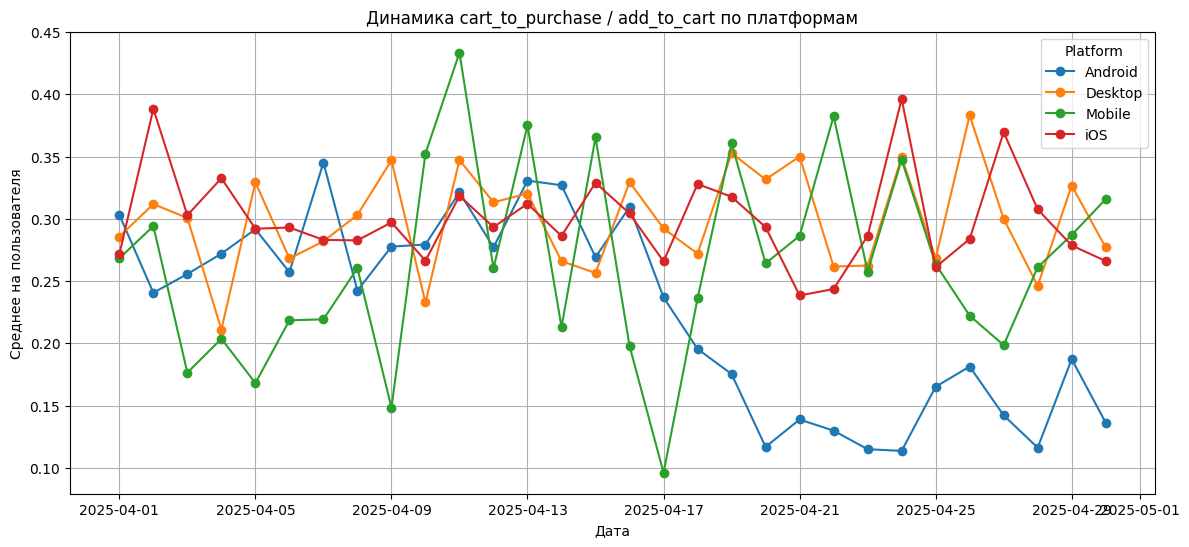

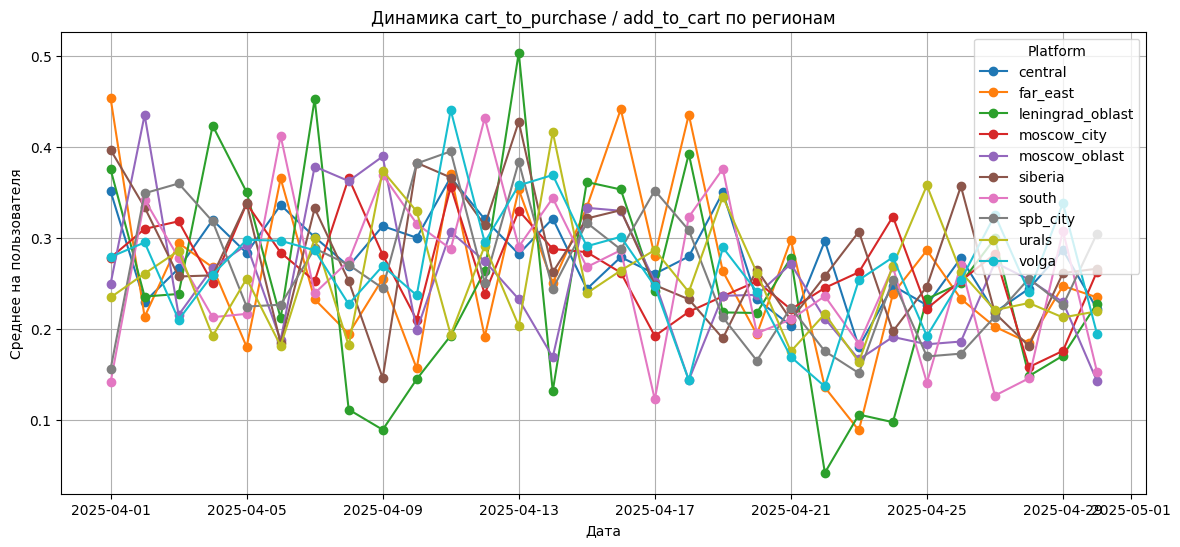

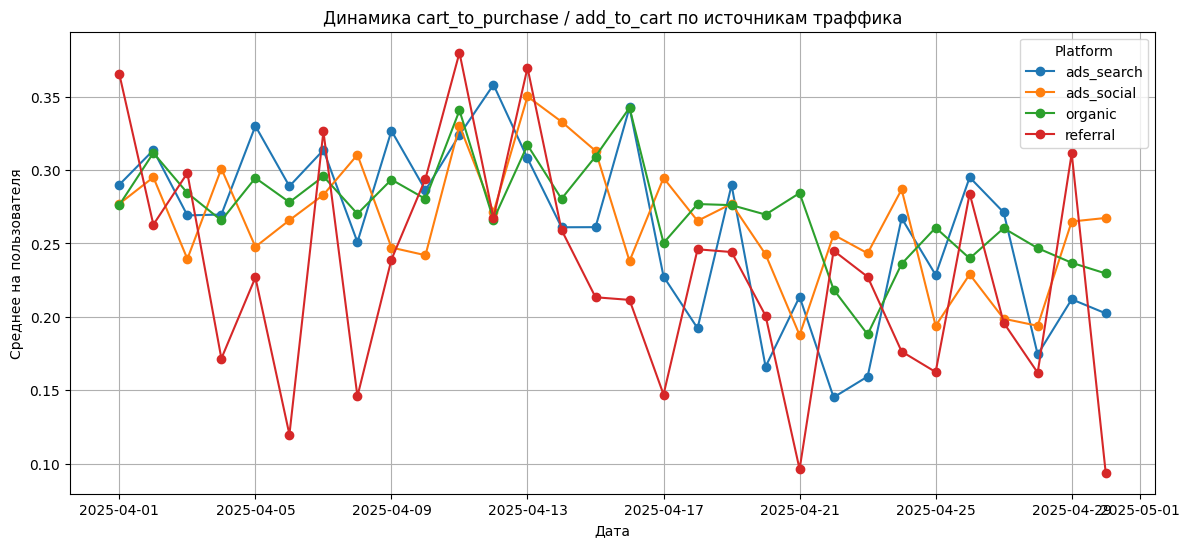

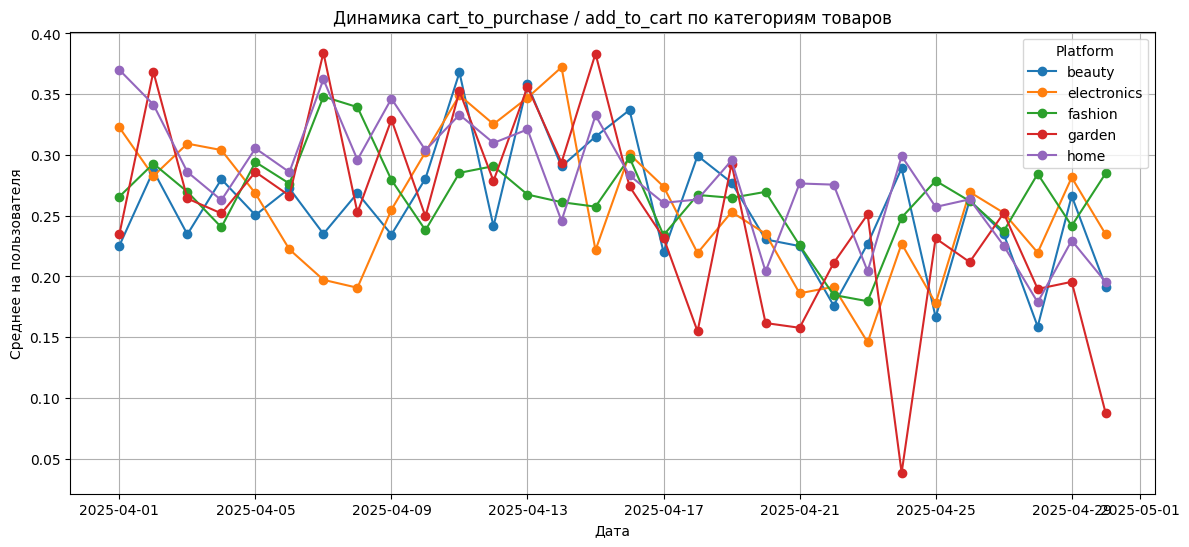

In [145]:
# your code is here

# Интересующие события
events_of_interest = ['view_item', 'add_to_cart', 'purchase']

# Берём только нужные события
filtered = df[df['event'].isin(events_of_interest)]

# события для каждой сессии и дня
session_events = (
    filtered.groupby(['session_id', 'date', 'platform', 'region', 'channel', 'category'])['event']
    .agg(set)
    .reset_index()
)

# Флаги конверсий
session_events['cart_to_purchase'] = session_events['event'].apply(lambda x: 'add_to_cart' in x and 'purchase' in x)
session_events['add_to_cart'] = session_events['event'].apply(lambda x: 'add_to_cart' in x)

# Считаем метрику на уровне пользователя (session_id + дата + срез)
user_level = (
session_events.groupby(['date','session_id','platform','region','channel','category'])
.agg({'cart_to_purchase':'sum','add_to_cart':'sum'})
.reset_index()
)


# Рассчитываем отношение (если add_to_cart = 0, то метрика = NaN)
user_level['ctr'] = user_level['cart_to_purchase'] / user_level['add_to_cart'].replace(0, pd.NA)


# Среднее на пользователя по каждому срезу
grouped = (
user_level.groupby(['date','platform','region','channel','category'])
['ctr'].mean()
.reset_index()
)


# Пример графика по платформам
pivot_platform = grouped.pivot_table(index='date', columns='platform', values='ctr')


plt.figure(figsize=(14, 6))
pivot_platform.plot(marker="o", ax=plt.gca())
plt.title("Динамика cart_to_purchase / add_to_cart по платформам")
plt.ylabel("Среднее на пользователя")
plt.xlabel("Дата")
plt.legend(title="Platform")
plt.grid(True)
plt.show()

# Пример графика по регионам
pivot_platform = grouped.pivot_table(index='date', columns='region', values='ctr')


plt.figure(figsize=(14, 6))
pivot_platform.plot(marker="o", ax=plt.gca())
plt.title("Динамика cart_to_purchase / add_to_cart по регионам")
plt.ylabel("Среднее на пользователя")
plt.xlabel("Дата")
plt.legend(title="Platform")
plt.grid(True)
plt.show()

# Пример графика по источникам трафика
pivot_platform = grouped.pivot_table(index='date', columns='channel', values='ctr')


plt.figure(figsize=(14, 6))
pivot_platform.plot(marker="o", ax=plt.gca())
plt.title("Динамика cart_to_purchase / add_to_cart по источникам траффика")
plt.ylabel("Среднее на пользователя")
plt.xlabel("Дата")
plt.legend(title="Platform")
plt.grid(True)
plt.show()

# Пример графика по категориям товаров
pivot_platform = grouped.pivot_table(index='date', columns='category', values='ctr')


plt.figure(figsize=(14, 6))
pivot_platform.plot(marker="o", ax=plt.gca())
plt.title("Динамика cart_to_purchase / add_to_cart по категориям товаров")
plt.ylabel("Среднее на пользователя")
plt.xlabel("Дата")
plt.legend(title="Platform")
plt.grid(True)
plt.show()

На первом графике явно видна динамика снижения конверсии в покупку начиная с середины месяца для пользователе Android.

#### **4. Детальные срезы — 1 балл**
1. Постройте динамику события для iOS и Android с разложением по версиям приложения.
2. Помогло ли это локализовать проблему?

*В этом пункте в качестве события продолжаем смотреть метрику среднего на пользователя*

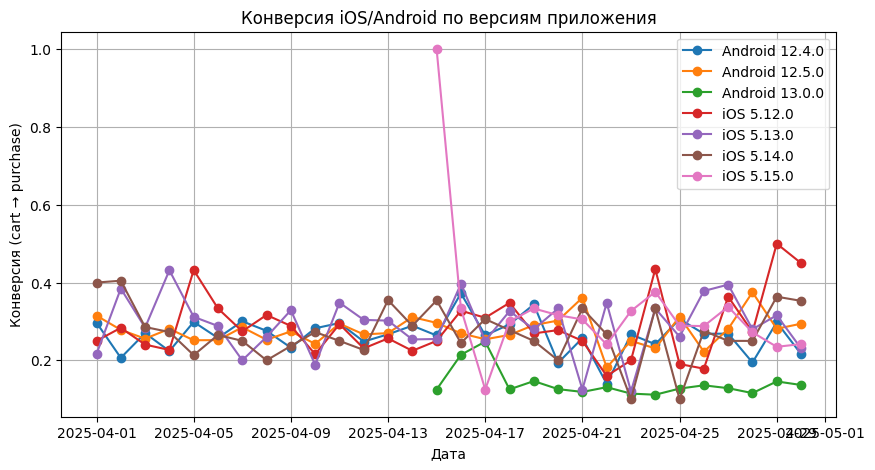

In [146]:
# your code is here

group_cols = ["date", "platform", "app_version"]
agg = df.groupby(group_cols + ["event"]).size().unstack(fill_value=0).reset_index()

for col in ["add_to_cart", "purchase"]:
    if col not in agg.columns:
        agg[col] = 0

agg["conversion"] = (
    agg["purchase"].where(agg["add_to_cart"] > 0, 0) /
    agg["add_to_cart"].where(agg["add_to_cart"] > 0, 1)
)

# Фильтруем только мобильные платформы
mobile_trend = agg[agg["platform"].isin(["iOS", "Android"])]

#график
plt.figure(figsize=(10, 5))
for (platform, version), grp in mobile_trend.groupby(["platform", "app_version"]):
    plt.plot(grp["date"], grp["conversion"], marker="o", label=f"{platform} {version}")

plt.title("Конверсия iOS/Android по версиям приложения")
plt.xlabel("Дата")
plt.ylabel("Конверсия (cart → purchase)")
plt.legend()
plt.grid(True)
plt.show()


На графике видно как проседает по конверсии версия Android 13.0.0

#### **5. Поиск причин — 1 балл**
1. Для проблемной платформы постройте динамику ВСЕХ событий в разрезе версий приложения.
2. Сформулируйте гипотезу, что именно могло пойти не так в новом релизе? Может быть, пользователи стали заменять один функционал другим?

*В этом пункте в качестве событий продолжаем смотреть метрику среднего на пользователя*

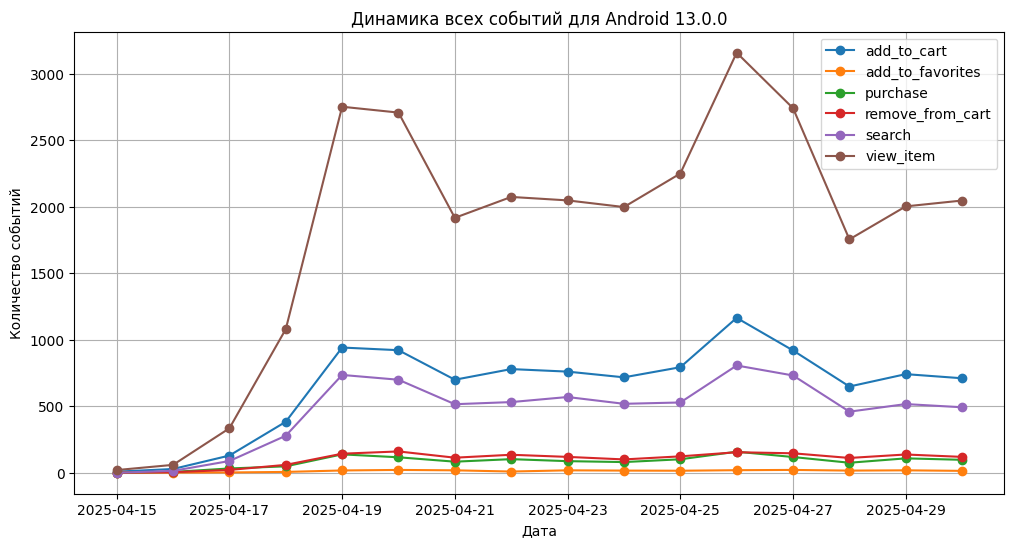

In [147]:
# your code is here
# Фильтруем Android 13.0.0
android_13 = df[(df["platform"] == "Android") & (df["app_version"].str.startswith("13.0.0"))]

#количество всех событий по дате и версии
event_trend = android_13.groupby(["date", "app_version", "event"]).size().unstack(fill_value=0).reset_index()

# график
plt.figure(figsize=(12, 6))
for event in event_trend.columns[2:]:  # первые две колонки: date, app_version
    plt.plot(event_trend["date"], event_trend[event], marker="o", label=event)

plt.title("Динамика всех событий для Android 13.0.0")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.legend()
plt.grid(True)
plt.show()


**Гипотеза**: проблема в новом релизе Android 13.0.0

Низкая конверсия add_to_cart в purchase на Android 13.0.0
На графике конверсии видно, что пользователи Android 13.0.0 совершают гораздо меньше покупок по сравнению с другими версиями Android и iOS.

Активность пользователей смещена на другие события
График всех событий для Android 13.0.0 показывает высокую активность view_item и add_to_cart, но низкую конверсию в purchase.
Также можно заметить, что избранное практически не используется, что может говорить о том, что корзиной могут пользоваться как избранным.

#### **6. Новости для команды — 1 балл**

На основе проведённого расследования подготовьте сообщение для команды о том, что именно пошло не так.



**Возможная причина:**

Ошибка или баг в процессе оформления покупки на Android 13.0.0.

Пользователи начали активно использовать функцию «добавить в избранное» вместо покупки.

UX изменения нового релиза могли усложнить процесс оплаты.

**Рекомендации для команды**

Провести техническую проверку всего процесса покупки на устройствах с Android 13.0.0.

Проанализировать все пути пользователей, которые заходят в add_to_cart, но не доходят до purchase.

Нужно убедиться, что сервис оплаты корректно работает на Android 13. Если есть ошибки, например, не проходят платежи, это может объяснять низкий процент завершённых покупок.

Рассмотреть возможность короткого A/B теста с предыдущей версией приложения для сравнения конверсии.

**Вывод**: пользователи Android 13.0.0 видят товары и добавляют их в корзину, но почти не завершают покупку. Проблема может быть технической или связанной с неудобным интерфейсом, например, сложная форма оплаты, новые шаги, которых раньше не было.